
# Telecom X — Analisis de Evasion de Clientes (Churn)

Este notebook implementa un flujo **ETL + EDA** para el dataset de **Telecom X**.  
Incluye carga desde la API (JSON), limpieza/estandarizacion, analisis descriptivo, visualizaciones y un informe final.


In [131]:

#setup basico
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import ast
import seaborn as sns


#esto pone las opciones de visualizacion tranqui
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 160)

#ruta para guardar outputs locales
OUT_DIR = Path('outputs')
OUT_DIR.mkdir(exist_ok=True)


In [132]:

#carga de datos directo desde la api de github en formato json
url = 'https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/main/TelecomX_Data.json'

#leo el json directo a dataframe
df = pd.read_json(url)

#vistazo rapido
df_head = df.head(10)
df_shape = df.shape
df_head, df_shape


(   customerID Churn                                           customer                                            phone  \
 0  0002-ORFBO    No  {'gender': 'Female', 'SeniorCitizen': 0, 'Part...   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
 1  0003-MKNFE    No  {'gender': 'Male', 'SeniorCitizen': 0, 'Partne...  {'PhoneService': 'Yes', 'MultipleLines': 'Yes'}   
 2  0004-TLHLJ   Yes  {'gender': 'Male', 'SeniorCitizen': 0, 'Partne...   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
 3  0011-IGKFF   Yes  {'gender': 'Male', 'SeniorCitizen': 1, 'Partne...   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
 4  0013-EXCHZ   Yes  {'gender': 'Female', 'SeniorCitizen': 1, 'Part...   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
 5  0013-MHZWF    No  {'gender': 'Female', 'SeniorCitizen': 0, 'Part...   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
 6  0013-SMEOE    No  {'gender': 'Female', 'SeniorCitizen': 1, 'Part...   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
 7  0014

In [133]:

#inspeccion estructura columnas y tipos
#info general del dataset
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   customerID  7267 non-null   object
 1   Churn       7267 non-null   object
 2   customer    7267 non-null   object
 3   phone       7267 non-null   object
 4   internet    7267 non-null   object
 5   account     7267 non-null   object
dtypes: object(6)
memory usage: 340.8+ KB


In [134]:
#ver todas las columnas
print(df.columns.tolist())
#valores únicos de Churn
print(df['Churn'].unique())

#conteo incluyendo nulos
print(df['Churn'].value_counts(dropna=False))


['customerID', 'Churn', 'customer', 'phone', 'internet', 'account']
['No' 'Yes' '']
Churn
No     5174
Yes    1869
        224
Name: count, dtype: int64


In [135]:
#lista de columnas y tipos
pd.DataFrame({'columna': df.columns, 'dtype': df.dtypes.astype(str)})


,columna,dtype
customerID,customerID,object
Churn,Churn,object
customer,customer,object
phone,phone,object
internet,internet,object
account,account,object


In [112]:
#reemplazar vacío por NaN y mapear a binario
df['churn_bin'] = (
    df['Churn']
    .replace({'Yes': 1, 'No': 0, '': np.nan})
)

#eliminar filas con NaN en churn_bin
base = df.dropna(subset=['churn_bin'])

#pasar a entero
base['churn_bin'] = base['churn_bin'].astype(int)

#resetear índices
base = base.reset_index(drop=True)

#ver distribución final
print(base['churn_bin'].value_counts())


churn_bin
0    5174
1    1869
Name: count, dtype: int64


/tmp/ipython-input-4156377152.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({'Yes': 1, 'No': 0, '': np.nan})
/tmp/ipython-input-4156377152.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base['churn_bin'] = base['churn_bin'].astype(int)


In [113]:
#valores ausentes por columna
na_counts = df.isna().sum().sort_values(ascending=False)

#filas duplicadas en customerid
dup_count = df['customerID'].duplicated().sum()

na_counts, dup_count


(churn_bin     224
 Churn           0
 customerID      0
 customer        0
 phone           0
 internet        0
 account         0
 dtype: int64,
 np.int64(0))

In [114]:
#chequeo final de nulos y tipos despues de limpieza
na_after = df.isna().sum().sort_values(ascending=False)
types_after = df.dtypes.astype(str)
na_after.head(20), types_after


(churn_bin     224
 Churn           0
 customerID      0
 customer        0
 phone           0
 internet        0
 account         0
 dtype: int64,
 customerID     object
 Churn          object
 customer       object
 phone          object
 internet       object
 account        object
 churn_bin     float64
 dtype: object)

In [138]:
#convertir strings que son diccionarios a diccionarios reales
for col in ['customer','phone','internet','account']:
    df[col] = df[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

#aplanar columna customer
customer_df = df['customer'].apply(pd.Series)
df = pd.concat([df, customer_df], axis=1)

#aplanar columna account y sacar facturacion mensual
account_df = df['account'].apply(pd.Series)
charges_df = account_df['Charges'].apply(pd.Series)
df['monthly_charges'] = charges_df['Monthly'].astype(float)

#limpiar 'Total' antes de convertir a float
df['total_charges'] = pd.to_numeric(charges_df['Total'], errors='coerce')

#ahora podemos calcular cuentas_diarias
df['cuentas_diarias'] = df['monthly_charges'] / 30.0

#revisar primeras filas
print('#primeras filas de df con cuentas_diarias')
display(df[['customerID','monthly_charges','total_charges','cuentas_diarias',]].head())


#primeras filas de df con cuentas_diarias


,customerID,monthly_charges,total_charges,cuentas_diarias
0,0002-ORFBO,65.6,593.30,2.186667
1,0003-MKNFE,59.9,542.40,1.996667
2,0004-TLHLJ,73.9,280.85,2.463333
3,0011-IGKFF,98.0,1237.85,3.266667
4,0013-EXCHZ,83.9,267.40,2.796667


# Descripcion numericas


,mean,median,std,min,max
churn_bin,0.265370,0.000000,0.441561,0.000000,1.000000
SeniorCitizen,0.162653,0.000000,0.369074,0.000000,1.000000
tenure,32.346498,29.000000,24.571773,0.000000,72.000000
monthly_charges,64.720098,70.300000,30.129572,18.250000,118.750000
total_charges,2280.634213,1391.000000,2268.632997,18.800000,8684.800000
cuentas_diarias,2.157337,2.343333,1.004319,0.608333,3.958333



# Cardinalidad de variables categoricas


,0
Partner,2
gender,2
Dependents,2
Churn,3
customerID,7267


#churn - media: 0.2654, mediana: 0.0, moda: 0.0


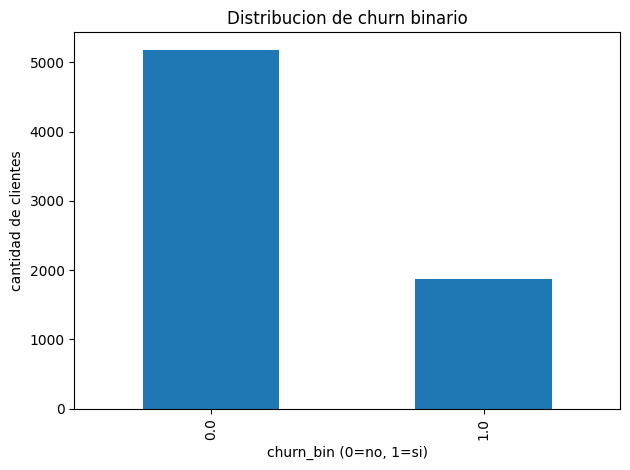

In [101]:
#empezamos el analisis

#numericas: media, mediana, std, min, max
desc_num = df.select_dtypes(include=[np.number]).agg(['mean','median','std','min','max']).T

#categoricas planas y cardinalidad
cat_cols_flat = [c for c in df.select_dtypes(include='object').columns
                 if df[c].apply(lambda x: isinstance(x, dict)).sum() == 0]
card = pd.Series({c: df[c].nunique(dropna=True) for c in cat_cols_flat}).sort_values()

#imprimir resultados
print('# Descripcion numericas')
display(desc_num)
print('\n# Cardinalidad de variables categoricas')
display(card.head(20))

#distribucion de churn
if churn_col is not None and (churn_col + '_bin') in df.columns:
    churn_clean = df[churn_col + '_bin'].dropna()

    #calculo media, mediana y moda
    media = churn_clean.mean()
    mediana = churn_clean.median()
    moda = churn_clean.mode()[0]
    print(f'#churn - media: {media:.4f}, mediana: {mediana}, moda: {moda}')

    #grafico
    vc = churn_clean.value_counts().sort_index()
    fig = plt.figure()
    vc.plot(kind='bar')
    plt.title('Distribucion de churn binario')
    plt.xlabel('churn_bin (0=no, 1=si)')
    plt.ylabel('cantidad de clientes')
    plt.tight_layout()
    plt.show()


In [88]:
#guardo version limpia por si las dudas
clean_path = OUT_DIR / 'telecomx_clean.csv'
df.to_csv(clean_path, index=False)
clean_path


PosixPath('outputs/telecomx_clean.csv')

In [137]:
#convertir strings que son diccionarios a diccionarios reales
for col in ['customer','phone','internet','account']:
    df[col] = df[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

#aplanar columna customer
customer_df = df['customer'].apply(pd.Series)
df = pd.concat([df, customer_df], axis=1)

#aplanar columna phone
phone_df = df['phone'].apply(pd.Series)
df = pd.concat([df, phone_df], axis=1)

#aplanar columna internet
internet_df = df['internet'].apply(pd.Series)
df = pd.concat([df, internet_df], axis=1)

#aplanar columna account y sacar facturacion mensual
account_df = df['account'].apply(pd.Series)
charges_df = account_df['Charges'].apply(pd.Series)
df['monthly_charges'] = charges_df['Monthly'].astype(float)

#limpiar 'Total' antes de convertir a float
df['total_charges'] = pd.to_numeric(charges_df['Total'], errors='coerce')

#ahora podemos calcular cuentas_diarias
df['cuentas_diarias'] = df['monthly_charges'] / 30.0

#revisar primeras filas
print('#primeras filas de df con cuentas_diarias')
display(df[['customerID','monthly_charges','total_charges','cuentas_diarias']].head())


#algo primeras filas de df con cuentas_diarias


,customerID,monthly_charges,total_charges,cuentas_diarias
0,0002-ORFBO,65.6,593.30,2.186667
1,0003-MKNFE,59.9,542.40,1.996667
2,0004-TLHLJ,73.9,280.85,2.463333
3,0011-IGKFF,98.0,1237.85,3.266667
4,0013-EXCHZ,83.9,267.40,2.796667


In [121]:
#detectar columnas duplicadas
duplicadas = df.columns[df.columns.duplicated()].unique()

if len(duplicadas) > 0:
    print("Columnas duplicadas encontradas:")
    for col in duplicadas:
        idxs = [i for i, c in enumerate(df.columns) if c == col]
        print(f" - {col}: posiciones {idxs}")
else:
    print("No hay columnas duplicadas")

#eliminar duplicadas (conservando la primera)
df = df.loc[:, ~df.columns.duplicated()]
print("\nColumnas finales después de limpiar duplicadas:")
print(df.columns.tolist())


Columnas duplicadas encontradas:
 - gender: posiciones [7, 15, 20, 25]
 - SeniorCitizen: posiciones [8, 16, 21, 26]
 - Partner: posiciones [9, 17, 22, 27]
 - Dependents: posiciones [10, 18, 23, 28]
 - tenure: posiciones [11, 19, 24, 29]

Columnas finales después de limpiar duplicadas:
['customerID', 'Churn', 'customer', 'phone', 'internet', 'account', 'churn_bin', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'monthly_charges', 'total_charges', 'cuentas_diarias']


In [127]:
#expandir account
account_df = df['account'].apply(pd.Series)

#concatenar columnas de Contract, PaperlessBilling y PaymentMethod
df = pd.concat([df, account_df[['Contract','PaperlessBilling','PaymentMethod']]], axis=1)

#limpiar duplicadas por si acaso
df = df.loc[:, ~df.columns.duplicated()]

print("Columnas actuales después de expandir account:")
print(df.columns.tolist())


Columnas actuales después de expandir account:
['customerID', 'Churn', 'customer', 'phone', 'internet', 'account', 'churn_bin', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'monthly_charges', 'total_charges', 'cuentas_diarias', 'Contract', 'PaperlessBilling', 'PaymentMethod']


/tmp/ipython-input-2331105714.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(pd.cut(df['tenure'], bins=10))['churn_bin'].mean().plot(
/tmp/ipython-input-2331105714.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='churn_bin', y='monthly_charges', data=df, palette=['skyblue','salmon'], ax=axes[4])


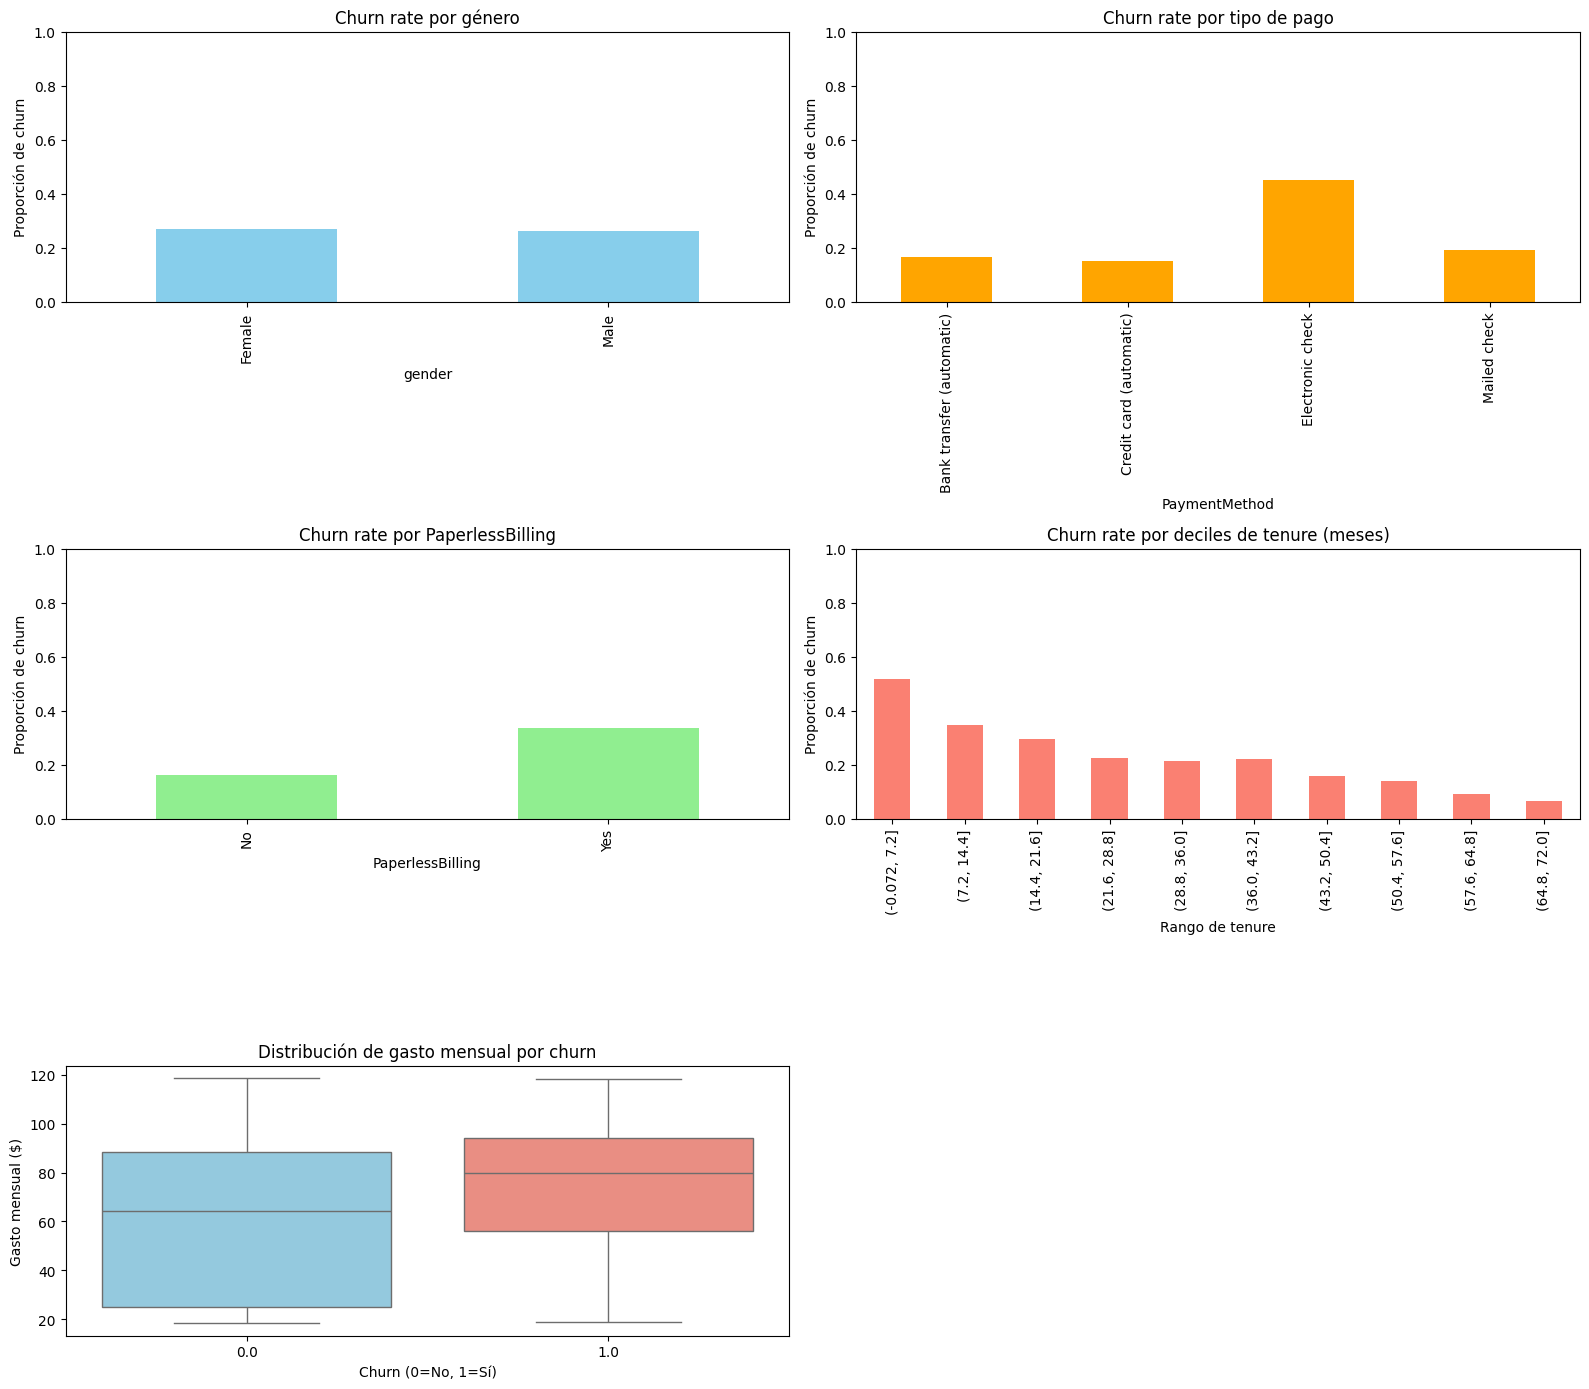

In [130]:
#asegurarnos de que no haya columnas duplicadas
df = df.loc[:, ~df.columns.duplicated()]

fig, axes = plt.subplots(3, 2, figsize=(16, 14))
axes = axes.flatten()

#Gender
if 'gender' in df.columns:
    df.groupby('gender')['churn_bin'].mean().plot(
        kind='bar', ax=axes[0], color='skyblue'
    )
    axes[0].set_title('Churn rate por género')
    axes[0].set_ylabel('Proporción de churn')
    axes[0].set_ylim(0, 1)

#PaymentMethod
if 'PaymentMethod' in df.columns:
    df.groupby('PaymentMethod')['churn_bin'].mean().plot(
        kind='bar', ax=axes[1], color='orange'
    )
    axes[1].set_title('Churn rate por tipo de pago')
    axes[1].set_ylabel('Proporción de churn')
    axes[1].set_ylim(0, 1)

#PaperlessBilling
if 'PaperlessBilling' in df.columns:
    df.groupby('PaperlessBilling')['churn_bin'].mean().plot(
        kind='bar', ax=axes[2], color='lightgreen'
    )
    axes[2].set_title('Churn rate por PaperlessBilling')
    axes[2].set_ylabel('Proporción de churn')
    axes[2].set_ylim(0, 1)

#Tenure (numérico → bins)
if 'tenure' in df.columns:
    df.groupby(pd.cut(df['tenure'], bins=10))['churn_bin'].mean().plot(
        kind='bar', ax=axes[3], color='salmon'
    )
    axes[3].set_title('Churn rate por deciles de tenure (meses)')
    axes[3].set_ylabel('Proporción de churn')
    axes[3].set_xlabel('Rango de tenure')
    axes[3].set_ylim(0, 1)
#Monthly Charges
if 'monthly_charges' in df.columns:
    sns.boxplot(x='churn_bin', y='monthly_charges', data=df, palette=['skyblue','salmon'], ax=axes[4])
    axes[4].set_title('Distribución de gasto mensual por churn')
    axes[4].set_xlabel('Churn (0=No, 1=Sí)')
    axes[4].set_ylabel('Gasto mensual ($)')

#elimino ejes sobrantes si hay más espacios que gráficos
for j in range(5, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



## Informe Final

Objetivo.

Entender factores asociados a la evasion (churn) para orientar acciones de retencion.  
ETL. Carga directa desde API (JSON), normalizacion de nombres, parseo de fechas, casteo de montos, limpieza de duplicados.  
EDA. Distribucion global de churn, tasas por categorias
(género, metodo de pago, etc. segun disponibilidad), comparaciones numericas por churn y matriz de correlacion.  

Hallazgos clave:

- No tenemos una correlación fuerte entre el churn por género.
- Encontramos que el churn se generaba con una mayor tendencia por los tipos de pago electrónicos, confirmando la tendencia con el tipo de facturación sin papel.
- El churn por tenure decrece mientras la cantidad de tiempo va creciendo, lo cual es de esperar, ya que los clientes que deciden quedarse mas tiempo, suelen estar mas atentos a los pagos del servicio.
- Encontramos además que el churn por pago mensual ocurre en mayor medida con los planes más caros.

Recomendaciones iniciales.
1) Priorizar intervenciones en segmentos con mayor tasa de churn (ofertas, contacto proactivo).  
2) Revisar friccion en metodos de pago y contratos mes a mes.  
3) Construir un modelo predictivo con variables seleccionadas del EDA y validar con AUC/Recall en clase positiva.  
4) Implementar monitoreo mensual de tasa de churn y cohortes.
